# Lab 8: Principal Component Analysis

In this lab assignment, we will implement Principal Components Analysis (PCA) using a dataset on kidney disease and its correlates. 

**Due Date: Tuesday, December 3, 11:59 PM PT.**

### Collaboration Policy
Data science is a collaborative activity. While you may talk with others about this assignment, we ask that you **write your solutions individually**. If you discuss the assignment with others, please **include their names** in the cell below.

**Collaborators:** *list names here*

In [2]:
# Run this cell to set up your notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

plt.style.use('fivethirtyeight') # Use plt.style.available to see more styles
sns.set()
sns.set_context("talk")
%matplotlib inline

<br/>

In lecture we discussed how Principal Component Analysis (PCA) can be used for dimensionality reduction. 

In this lab, you'll learn how to perform PCA using the `np.linalg` package, evaluate the total variance explained by the dominant  principal components, and then visualize the loading of each feature in the first two principal components.

# Part 1: The Kidney Disease Dataset

To begin, run the following cell to load the dataset into this notebook. This dataset represents a number of features measured on patients at intake and whether they were diagnosed with some form of kidney disease. Be sure to reference the separate metadata file for feature interpretation. 

In [3]:
# Load the data
kidney = pd.read_table("./data/kidney_disease.csv", sep = ",")
kidney.head()

,id,age,bp,sg,al,su,rbc,pc,pcc,ba,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,...,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,...,38,6000,NaN,no,no,no,good,no,no,ckd
2,2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,...,31,7500,NaN,no,yes,no,poor,no,yes,ckd
3,3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,...,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
4,4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,...,35,7300,4.6,no,no,no,good,no,no,ckd


We need to extract our "target" variable, `classification` which is a binomial variable indicating whether a patient was diagnosed with some kidney disease (ckd) or not (notckd). Note that we are not planning to classify observations as either 0 or 1, we are only unearthing the structure of our data in relation to kidney disease *i.e.* our task is unsupervised learning. 

For the purposes of PCA, we'll also remove features that aren't or can't be interpreted as quantitative variables. In general we don't include variables that come from different types of distributions in a PCA, but see [multiple correspondence analysis](https://pypi.org/project/mca/) for a method better-suited for dimensionality reduction of nominal categorical variables. 

In [4]:
# Select useable features
kidney = kidney[["age","bp","al","su","bu","sc","sod","pot","hemo","wc","rc","classification"]].dropna()
kidney_target = kidney["classification"].values
kidney.drop("classification", axis = 1, inplace = True)

kidney.head()

,age,bp,al,su,bu,sc,sod,pot,hemo,wc,rc
3,48.0,70.0,4.0,0.0,56.0,3.8,111.0,2.5,11.2,6700,3.9
5,60.0,90.0,3.0,0.0,25.0,1.1,142.0,3.2,12.2,7800,4.4
9,53.0,90.0,2.0,0.0,107.0,7.2,114.0,3.7,9.5,12100,3.7
11,63.0,70.0,3.0,0.0,60.0,2.7,131.0,4.2,10.8,4500,3.8
12,68.0,70.0,3.0,1.0,72.0,2.1,138.0,5.8,9.7,12200,3.4


## Question 1: Standardization and SVD

### Question 1a

To apply PCA, we will first need to standardize our data. Use `StandardScaler` and `fit_transform` from `sklearn` to do so. The output will be a 2D matrix with a column for each standardized feature, so you should then convert this to a Dataframe with appropriate column names. 

In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
kidney_stand = pd.DataFrame(scaler.fit_transform(kidney), columns = kidney.columns)
kidney_stand.head()

,age,bp,al,su,bu,sc,sod,pot,hemo,wc,rc
0,-0.242928,-0.413641,2.249294,-0.379817,0.007271,0.434566,-3.836915,-0.683074,-0.713460,-0.637910,-0.860451
1,0.526344,1.051629,1.532675,-0.379817,-0.604528,-0.402953,0.488711,-0.452599,-0.366201,-0.263120,-0.364767
2,0.077602,1.051629,0.816055,-0.379817,1.013778,1.489221,-3.418306,-0.287975,-1.303801,1.201971,-1.058725
3,0.718662,-0.413641,1.532675,-0.379817,0.086213,0.093355,-1.046189,-0.123350,-0.852364,-1.387491,-0.959588
4,1.039193,-0.413641,1.532675,0.600205,0.323038,-0.092761,-0.069434,0.403448,-1.234349,1.236043,-1.356135


### Question 1b

As you may recall from lecture, PCA is a specific application of the singular value decomposition (SVD) for matrices. In the following cell, let's use the `np.linalg.svd` function ([documentation](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.svd.html)) to compute the SVD of our `kidney_stand` data. 

Store the left singular vectors $U$, singular values $\Sigma$, and (transposed) right singular vectors $V^T$ in `u`, `s`, and `vt`, respectively. Set the `full_matrices` argument of `np.linalg.svd` to `False`.

In [7]:
u, s, vt = np.linalg.svd(kidney_stand, full_matrices = False)
u.shape, s, vt.shape

((209, 11),
 array([30.86760873, 16.81307502, 15.05784618, 13.65786208, 13.1952194 ,
        11.61689171, 10.31853169,  9.82389898,  8.65286594,  6.20137034,
         4.98589539]),
 (11, 11))

In [9]:
s

array([30.86760873, 16.81307502, 15.05784618, 13.65786208, 13.1952194 ,
       11.61689171, 10.31853169,  9.82389898,  8.65286594,  6.20137034,
        4.98589539])

### Question 1c

What can we learn from the singular values in `s`? Recall from lecture that the singular values represent the eigenvalues $\lambda$s associated with our principal components. 

The total variance of the data is also equal to the sum of the squares of the singular values divided by the number of data points, that is:

$$\text{Var}(X) = \sum_{i=1}^d \frac{\sigma_i^2}{N}$$

where for data $X$ with $N$ datapoints and $d$ features, $\sigma_i$ is the singular value corresponding to the $i$-th principal component, and $\text{Var}(X)$ is the total variance of the data. The right-hand side implies that the expression $\sigma_i^2/N$ is the amount of variance captured by the $i$-th principal component.

Compute the total variance of our standardized data below by summing the square of each singular value in `s` and dividing the result by the total number of data points. Store the result in the variable `kidney_total_variance`.

In [10]:
kidney_total_variance = np.sum(s**2)/len(kidney_stand)
print("cardio_total_variance: {:.3f} should approximately equal the sum of the feature variances: {:.3f}"
      .format(kidney_total_variance, np.sum(np.var(kidney_stand, axis=0))))

cardio_total_variance: 11.000 should approximately equal the sum of the feature variances: 11.000


As you should see, `kidney_total_variance` is equal to the sum of the standardized feature variances. Since our features are standardized, `kidney_total_variance` is equal to the number of original features.

# Question 2

### Question 2a

Let's now use only the first two principal components to see what a 2D version of our kidney data looks like.

Construct this 2D data by multiplying `kidney_stand` with the first two right singular vectors in `vt`. Because the first two vectors are directions for the first two principal components, this will project the kidney data to a 2D subspace.

**Hints:**
* To matrix-multiply two numpy arrays, use `@`. In case you're interested, the [matmul documentation](https://numpy.org/devdocs/reference/generated/numpy.matmul.html) contrasts the two methods.
* Note that in Question 1b, you computed `vt` (SVD decomposition is $U\Sigma V^T$). The first two right singular vectors in $V$ will be the two rows of `vt`, [transposed](https://numpy.org/devdocs/reference/generated/numpy.ndarray.T.html#numpy.ndarray.T) to be column vectors instead of row vectors. 
* Since we want to obtain a 2D version of our kidney dataset, the shape of `kidney_2d` should be (209, 2).

In [12]:
kidney_2d = kidney_stand @ vt[:2].T
kidney_2d

,0,1
0,2.590638,0.945656
1,0.439477,-0.590767
2,3.580867,0.101738
3,1.504507,0.811028
4,2.108935,-1.269697
...,...,...
204,-1.500309,0.102929
205,-2.007409,0.358852
206,-1.683182,1.342646
207,-1.501343,1.602568


Now, run the cell below to create the scatter plot of our 2D version of the kidney data, `kidney_2d`.

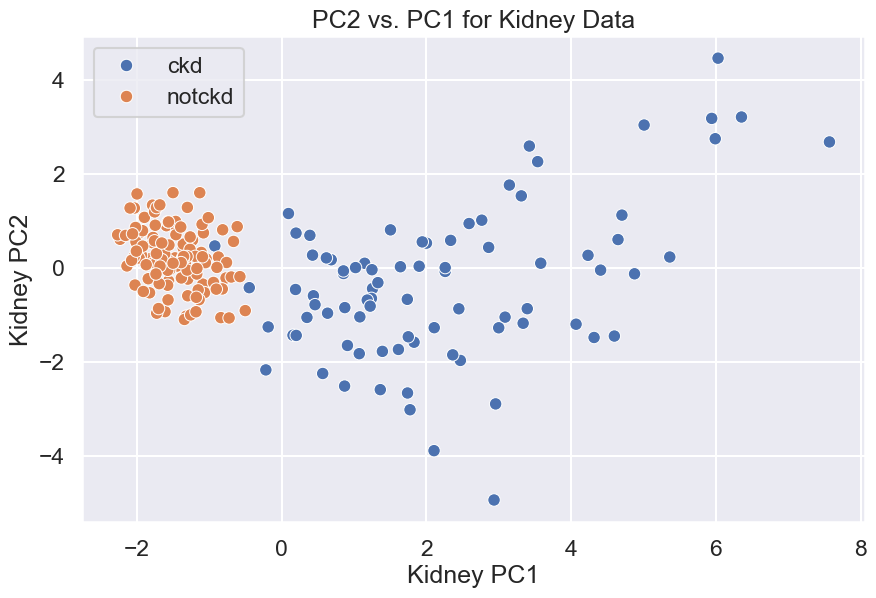

In [14]:
# just run this cell
plt.figure(figsize = (9, 6))
plt.title("PC2 vs. PC1 for Kidney Data")
plt.xlabel("Kidney PC1")
plt.ylabel("Kidney PC2")
sns.scatterplot(x = kidney_2d.loc[:, 0], y = kidney_2d.loc[:, 1], hue = kidney_target);

### Question 2b

What do you observe about the plot above? If you were given a point in the subspace defined by PC1 and PC2, how confident would be classifying that point as either having kidney disease or no disease?

**Your response**: We would be extremely confident in classifying that point as having kidney disease or not if we were looking at just the first two pc's. When observiving the plot we can very clearly see that ther's the cluster for "not kidney disease" and then "other" (being kidney disease)

In [15]:
s[0]

30.86760872986023

### Question 2c

What proportion of the total variance is accounted for when we project the kidney data down to two dimensions? Compute this quantity in the cell below by finding the proportion of total variance accounted for by the first two principal components.

In [16]:
variance_com = s**2/len(kidney_stand)

In [17]:
kidney_2d_variance = np.sum(variance_com[:2])/np.sum(variance_com)
kidney_2d_variance

0.5374026796185571

You should find that over half of the variation is explained by the two-dimensional projection!

### Question 2d

Here we plot the "loadings" of each variable associated with your first two principal components on the graph. The first eigenvector `vt` represents the "direction" of each feature in PC1, while the second represents their direction in PC2. We use these values as an endpoint for an arrow originating at 0,0. In similar fashion, we labels corresponding to the feature each arrow represents. 

*Note*: We multiplied the endpoints by some scalar so that they can be more readily interpreted on the figure. 

*Note*: We added some noise (offsets) along the y-axis to the labels so they can be read, but you may want to run the code a few times until you get random offsets that let you distinguish between nearby labels. 

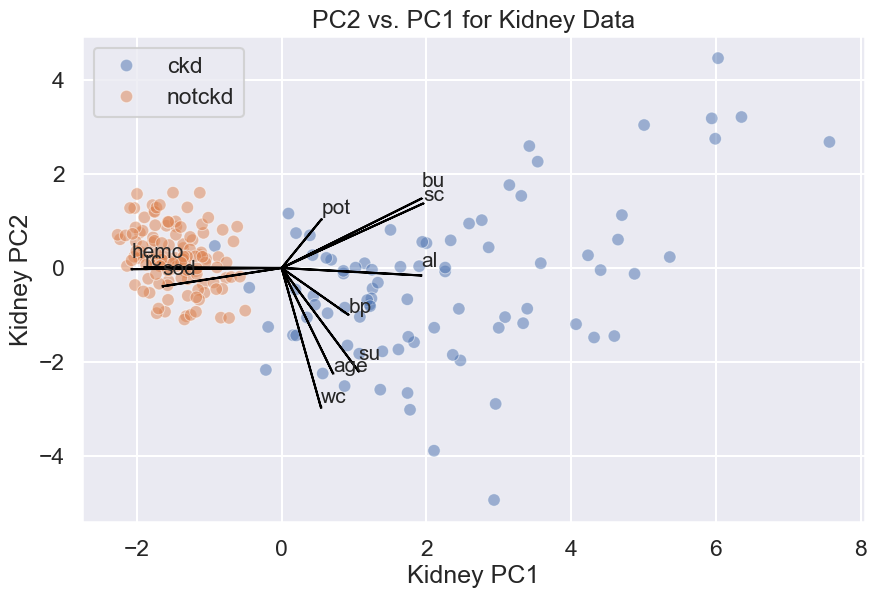

In [19]:
# just run this cell
offsets = np.random.uniform(0, 1, vt.shape[1])*.3
plt.figure(figsize = (9, 6))
plt.title("PC2 vs. PC1 for Kidney Data")
plt.xlabel("Kidney PC1")
plt.ylabel("Kidney PC2")
sns.scatterplot(x = kidney_2d.loc[:, 0], y = kidney_2d.loc[:, 1], hue = kidney_target, alpha = 0.5);

for i in range(vt.shape[1]):
    plt.arrow(0, 0, vt[0,i]*5, vt[1,i]*5, color = "black")
    plt.text(vt[0,i]*5, vt[1,i]*5 + offsets[i], kidney.columns[i], fontsize = "small")

Based on your interpretation of PC1 and PC2's loadings, which variables seem to be associated with kidney disease and in what direction?

**Your response**: A Variable that's primarily associated with Kidney disease would be al - Albumin -, in a positive direction with PC 1. The vector is nearly horizontal indicating a relation to PC1. Two variables that seem like they're associated with not having kidney disease would be hemo globin and soq/sog/so- (can't read it between the lines). They are also nearly purely horizontal indicating a strong relation with PC1. We care about these relations with PC1 because it seems you can draw a near perfect vertical line at pc1 = 0, indicating that PC1 most strongly relates to kidney disease. 

### Question 2e

Finally, create a barplot representing the amount of variance explained by each of your principal components, sorted from most to least. 

<Axes: >

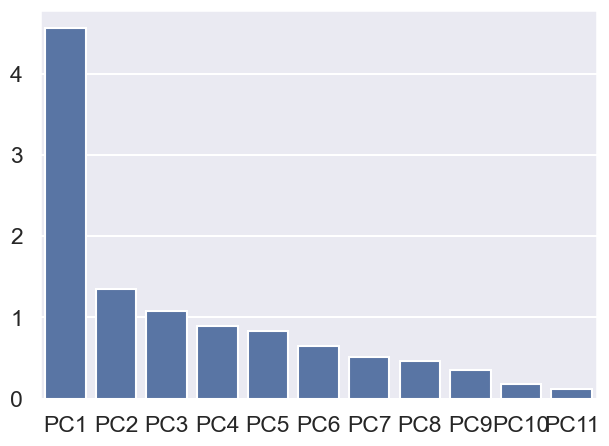

In [20]:
variance_com
sns.barplot(x = ["PC1", "PC2","PC3", "PC4","PC5","PC6", "PC7", "PC8", "PC9", "PC10","PC11"], y = variance_com)

In [21]:
np.sum(variance_com)

10.999999999999996

Do you think the first two PCs are a sufficient representation of the variation in the data? 

**Your response**Honestly I'm not sure but I'm leaning towards no. The sum of the variance should be 11, and the first two pc's combined account for what 53.7% of the variation in the data. While this definitely very significant, if we were to only represent the data using the two pc's there is a 46.3% loss of information. But as far as reducing our dimensions from 11 -> 2 and then maintaining 53.7% of the variation is sort of incredible. 

To double-check your work, the cell below will rerun all of the autograder tests.

## Submission

Make sure you have run all cells in your notebook in order. Then execute the following commands from the File menu:

* Save and Checkpoint
* Close and Halt

Then upload your .ipynb file to Canvas assignment Lab 8.